In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pyh5md
import scipy.signal
from glob import glob
import itertools
from matplotlib.figure import SubplotParams
from scipy.optimize import leastsq
from scipy.integrate import cumtrapz
import tidynamics
import os.path

plt.rcParams['figure.figsize'] = (5.6, 4.2)
plt.rcParams['figure.subplot.hspace'] = .25
plt.rcParams['figure.subplot.wspace'] = .3
plt.rcParams['figure.subplot.left'] = .24
plt.rcParams['figure.subplot.bottom'] = .15
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.right'] = 0.95

plt.rcParams['font.size'] = 16

π = np.pi


In [2]:
TYPE = 'h'

In [11]:
# Collect all simulation data in store

if TYPE == 'h':
    sp_runs = glob('/home/share/nanomotors/20180927/l69xy_'+TYPE+'_209*/l69*.h5')
else:
    sp_runs = glob('/home/share/nanomotors/20180927/l69xy_'+TYPE+'_20928*/l69*.h5')
    
sp_runs.sort()
print(len(sp_runs), 'runs found')


20 runs found


In [12]:
# For comparison, also list the equilibrium runs

eq_runs = glob('/home/share/nanomotors/20180927/l69xy_'+TYPE+'_p0_209*/l69*.h5')

eq_runs.sort()

print(len(eq_runs), 'runs found')


20 runs found


In [5]:
radius_data = []
v_mean = []

if TYPE=='h':
    slicer = slice(None, None, 5)
else:
    slicer = slice(1,None,1)
    
for r in sp_runs[:]:
    with pyh5md.File(r, 'r') as a:
        if a['parameters/do_hydro'][()] != (1 if TYPE=='h' else 0): continue

        L = a['particles/janus/box/edges'][:]

        obs = a['observables']
        el = pyh5md.element(obs, 'omega_body')
        omega_body_dt = el.time
        omega_body = el.value[slicer][:-1]
        el = pyh5md.element(obs, 'janus_pos')
        com_pos_dt = el.time
        com_pos = el.value[slicer][:-1]
        el = pyh5md.element(obs, 'janus_vel')
        com_vel_dt = el.time
        com_vel = el.value[slicer][:-1]

        janus = a['particles/janus']
        pos_0 = pyh5md.element(janus, 'position').value[0]
        el = pyh5md.element(janus, 'position')
        pos_dt = el.time
        pos = el.value[:]
        el = pyh5md.element(janus, 'image')
        im = el.value[:]
        im_dt = el.time
        pos += im*L

        # Define the direction of the long and short arms of the L

        idx_1, idx_2 = 5, 33
        d_20_0 = np.sqrt(np.sum((pos_0[idx_2]-pos_0[0])**2))
        u_perp = (pos[:,idx_2,:]-pos[:,0,:])/d_20_0

        d_4_0 = np.sqrt(np.sum((pos_0[idx_1]-pos_0[0])**2))
        u_para = (pos[:,idx_1,:]-pos[:,0,:])/d_4_0

        v_1 = np.sum(com_vel[::2]*u_para, axis=1)
        v_2 = np.sum(com_vel[::2]*u_perp, axis=1)
        v_3 = omega_body[:,2]
        
        radius_data.append(v_2.mean()/v_3.mean())
        v_mean.append((v_1.mean(), v_2.mean(), v_3.mean()))

v_mean = np.array(v_mean)


<IPython.core.display.Javascript object>


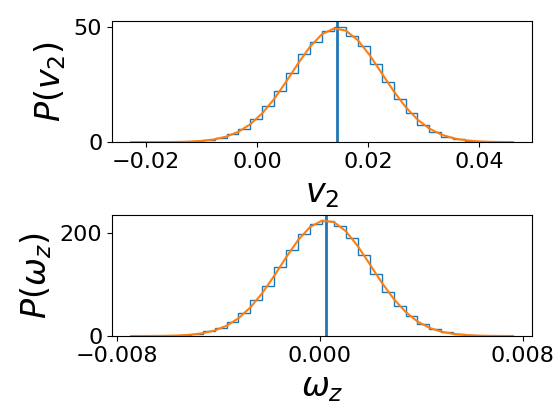

In [6]:
# plot velocity and angular velocity distributions

# mass of a bead
mb = 141.4
# moment of inertia Izz
Iz = 2.238e3*mb
# mass of the L particle
M = 108*mb

params = SubplotParams(left=0.2, bottom=0.2, hspace=0.6)
plt.figure(subplotpars=params)

plt.subplot(211)

count, bins, patches = plt.hist(v_2, bins=32, normed=True, histtype='step');
plt.axvline(v_2.mean(), lw=2);
plt.plot(bins, np.exp(-M*(bins-v_2.mean())**2/2)/np.sqrt(2*π/M))

x_max = np.max(np.abs(plt.xlim()))

plt.xlabel(r'$v_2$', fontsize=24)
plt.ylabel(r'$P(v_2)$', fontsize=24)

plt.subplot(212)

count, bins, patches = plt.hist(v_3, bins=32, normed=True, histtype='step');
plt.axvline(v_3.mean(), lw=2);
plt.plot(bins, np.exp(-Iz*(bins-v_3.mean())**2/2)/np.sqrt(2*π/Iz))

plt.xticks(np.linspace(-0.008, 0.008, 3))

plt.xlabel(r'$\omega_z$', fontsize=24)
plt.ylabel(r'$P(\omega_z)$', fontsize=24)

plt.savefig('L69xy_sp_hist_v2_omega_'+TYPE+'.pdf')

In [7]:
print("Radius", np.mean(radius_data), "+/-", np.std(radius_data))

Radius 55.51713934412495 +/- 7.016327890778559


In [8]:
v_mean.mean(axis=0)

array([-0.0005491 ,  0.01459586,  0.00026699])

<IPython.core.display.Javascript object>


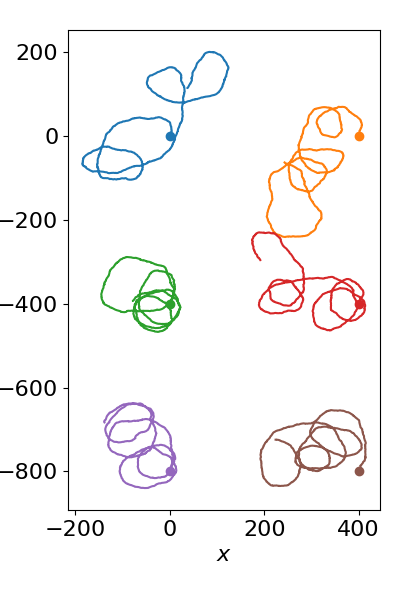

In [15]:
params = SubplotParams(left=0.17, bottom=0.15, hspace=0, wspace=0)


x_min, x_max = np.inf, -np.inf
y_min, y_max = np.inf, -np.inf

if TYPE=='h':
    space_x = 400
    space_y = 400
else:
    space_x = 600
    space_y = 600

nx = 2
ny = 3
n_samples = nx*ny

for i, r in enumerate(sp_runs[:n_samples]):
    with pyh5md.File(r, 'r') as a:
        obs = a['observables']
        sp_pos = pyh5md.element(obs, 'janus_pos').value[:,:2]

    x_min = min(sp_pos[:,0].min(), x_min)
    x_max = max(sp_pos[:,0].max(), x_max)
    y_min = min(sp_pos[:,1].min(), y_min)
    y_max = max(sp_pos[:,1].max(), y_max)

size_x = (nx-1)*(x_max-x_min + space_x)
size_y = (ny-1)*(y_max-y_min + space_y)
ratio = size_y/size_x

fig = plt.figure(subplotpars=params, figsize=(4, 6))
#fig.add_subplot(111, aspect=1)


x0 = 0
y0 = 0

for i, r in enumerate(sp_runs[:n_samples]):
    with pyh5md.File(r, 'r') as a:
        obs = a['observables']
        sp_pos = pyh5md.element(obs, 'janus_pos').value[:,:2]

    sp_pos -= sp_pos[0]   
    sp_pos += x0, y0
    
    l, = plt.plot(*sp_pos.T)
    plt.scatter([x0], [y0], color=l.get_color())
    
    x0 += space_x
    if (i+1)%nx == 0:
        x0 = 0
        y0 -= space_y


plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
delta = y2-y1 - (x2-x1)
if False:
    if delta>0:
        plt.xlim(x1 - delta/2, x2 + delta/2)
    else:
        plt.ylim(y1 + delta/2, y2 - delta/2)


plt.savefig('L69xy_sp_six_trajectories_'+TYPE+'.pdf')